In [7]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


filename = "datasets/original_dataset.xlsx"
df = pd.read_excel(filename, engine='openpyxl')

df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [8]:
# data type & selecting feature(baseline model only used long-history feature)
numeric_features = ['Long_1', 'Long_2', 'Long_3', 'Long_4', 'Long_5', 'Long_6',
                    'Long_7', 'Long_8', 'Long_9', 'Long_10','Short_1','Short_2',
                    'Short_3','Short_4','Short_5','Short_6','Short_7','Short_8','Short_9','Short_10']

# using linear intepolation
for feature in numeric_features:
    # create a intepolation function
    interpolator = interp1d(df['submission_year'], df[feature], kind='linear', fill_value='extrapolate')
    
    # fill in NA，transforming the outcome to Series
    interpolated_values = pd.Series(interpolator(df['submission_year']), name=feature)
    
    # using fillna method to fill into NA
    df[feature].fillna(interpolated_values, inplace=True)

df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


In [9]:
# Impute the DataFrame
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015.0,0.0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
1,410VKN,2015.0,0.0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
2,394ETK,2015.0,1.0,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
3,036KQK,2015.0,0.0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
4,996RNP,2015.0,0.0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,0.745562,0.940477,66.338224,6896.331199,71.340244,42912.46152,25271.78,45.238135,0.162112,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017.0,0.0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017.0,1.0,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017.0,1.0,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017.0,1.0,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


# Stage 1 modeling

In [10]:
# Separate data into training and validation sets
train_df = df[df['TrainVal'] == 'Train_60']
val_df = df[df['TrainVal'] == 'Val_40']


# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                 'Short_1','Short_2','Short_3','Short_4','Short_5',
                                 'Short_6','Short_7','Short_8','Short_9', 'Short_10'])
y_train = train_df['target']

X_val= val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                             'Short_1','Short_2','Short_3','Short_4','Short_5',
                                             'Short_6','Short_7','Short_8','Short_9', 'Short_10'])
y_val = val_df['target']



In [11]:
# data norminization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Define C for GridSearch
param_grid = {'C': [0.01, 0.06, 0.08, 0.1, 0.12, 1]}

# Logistic Regression (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='accuracy')

# Fit models to training data
grid_search.fit(X_train_scaled, y_train)

# Get the optimal C-value
best_C = grid_search.best_params_['C']
print("Best C:", best_C)

# Create and fit a model using the optimal value of C
lasso_model_best = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', random_state=42)
lasso_model_best.fit(X_train_scaled, y_train)

# Output feature selection results
selected_features = X_train.columns[lasso_model_best.coef_[0] != 0]
print("Feature selected:", selected_features)

# Evaluate model performance on validation sets
accuracy_combined = lasso_model_best.score(X_val_scaled, y_val)


print("Model accuracy on combined data:", accuracy_combined)



Best C: 0.08
Feature selected: Index(['Long_1', 'Long_2', 'Long_3', 'Long_4', 'Long_5', 'Long_6', 'Long_7'], dtype='object')
Model accuracy on combined data: 0.7771709448388858


In [12]:
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np


X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_val_scaled_selected = scaler.transform(X_val_selected)


# Initialize the KFold parameters
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Prepare empty arrays to store predictions
oof_predictions = np.zeros(X_train_scaled_selected.shape[0])
val_predictions = np.zeros(X_val_scaled_selected.shape[0])

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'n_estimators': [70, 100, 120],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6,0.7, 0.8, 0.9]
}

# Perform 2-Fold Cross-Validation with hyperparameter tuning
for train_index, test_index in kf.split(X_train_scaled_selected):
    # Split data into training and test for the current fold
    X_train_fold, X_test_fold = X_train_scaled_selected[train_index], X_train_scaled_selected[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    
    # Initialize the XGBoost classifier
    clf = xgb.XGBClassifier()
    
    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=3, verbose=1)
    
    # Fit the grid search to the training fold
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best estimator
    best_fold_clf = grid_search.best_estimator_
    
    # Predict on the test fold using the best estimator
    oof_predictions[test_index] = best_fold_clf.predict_proba(X_test_fold)[:, 1]

# After cross-validation, retrain the model on the full training set with the best parameters found
best_params = grid_search.best_params_
best_clf = xgb.XGBClassifier(**best_params)
best_clf.fit(X_train_scaled_selected, y_train)
print("Best parameters for 'old' model after all iterations:", grid_search.best_params_)



Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters for 'old' model after all iterations: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 70, 'subsample': 0.6}


In [13]:
# Predict on the validation set
val_predictions = best_clf.predict_proba(X_val_scaled_selected)[:, 1]

# Add the predictions to the train and validation dataframes
train_df['scores'] = oof_predictions
val_df['scores'] = val_predictions

# Concatenating vertically and merge with the original dataframe
all_data_with_scores = pd.concat([train_df, val_df], axis=0)
stage_2_df = pd.merge(df, all_data_with_scores[['UniqueID', 'scores']], on='UniqueID', how='left')

# Use only new data, which starts from row 2763 for the meta-model
stage_2_df_new = stage_2_df.iloc[2763:]

stage_2_df_new

/var/folders/ws/blgbwzr12n1ft67j1ff2cwh80000gn/T/ipykernel_99135/4153727499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['scores'] = oof_predictions
/var/folders/ws/blgbwzr12n1ft67j1ff2cwh80000gn/T/ipykernel_99135/4153727499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['scores'] = val_predictions


,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10,scores
2763,508XDL,2016.0,0.0,Val_40,2700.0,6.0,10162.0,150.0,3.0,5.0,...,0.868536,91.520897,14538.533330,66.706050,61129.72222,32239.45,80.734127,0.251121,0.000000,0.337070
2764,153NPQ,2016.0,0.0,Val_40,2900.0,2.0,0.0,724.0,176.0,1.0,...,0.880845,49.199558,5817.467500,49.223847,39944.04250,36838.49,12.007356,0.130428,0.000000,0.124813
2765,943ZYY,2016.0,1.0,Val_40,400.0,3.0,0.0,346.0,67.0,2.0,...,0.789127,39.795344,14341.450000,57.093785,89946.13333,69108.40,22.159208,0.132850,0.000000,0.210715
2766,661PQS,2016.0,0.0,Train_60,100.0,10.0,0.0,290.0,67.0,21.0,...,0.986737,36.774275,1987.306667,31.480221,20380.42000,18946.01,11.214517,0.113548,0.666667,0.340391
2767,403SNA,2016.0,1.0,Train_60,2300.0,3.0,0.0,190.0,48.0,4.0,...,0.988047,20.113561,4363.163333,31.869906,24862.13667,22157.22,18.798385,0.210578,0.000000,0.355645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017.0,0.0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667,0.402955
4595,538JZF,2017.0,1.0,Train_60,1600.0,0.0,0.0,338.0,3.0,1.0,...,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000,0.351181
4596,648WHI,2017.0,1.0,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667,0.279324
4597,899YZB,2017.0,1.0,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667,0.348799


# Stage 2 modeling

In [14]:
# Separate data into training and validation sets
train_df = stage_2_df_new[stage_2_df_new['TrainVal'] == 'Train_60']
val_df = stage_2_df_new[stage_2_df_new['TrainVal'] == 'Val_40']

# Old Data
old_data_end_index = 2763
old_data_indices = stage_2_df_new.iloc[:old_data_end_index].index
val_old = val_df[val_df.index.isin(old_data_indices)]

# New Data
new_data_start_index = 2763
new_data_indices = stage_2_df_new.iloc[new_data_start_index:].index
val_new = val_df[val_df.index.isin(new_data_indices)]

# Combined Data (Old + New)
val_combined = val_df.copy()

# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_train = train_df['target']

X_val_old = val_old.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val_old = val_old['target']
# New Data (from row 2763 onwards)
X_val_new = val_new.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val_new = val_new['target']
# Combined Old + New Data
X_val_combined = val_combined.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val_combined = val_combined['target']


In [15]:
# Train the XGBoost model with hyper parameter tuning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'n_estimators': [70, 100, 120],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6,0.7, 0.8, 0.9]
}
clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

best_clf = grid_search.best_estimator_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}


# test on full testing data

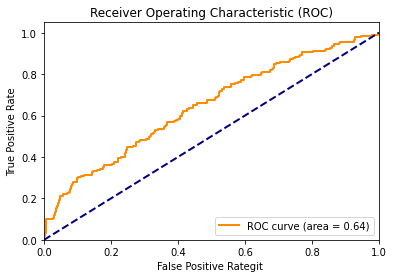

In [16]:
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set

y_pred = best_clf.predict_proba(X_val_combined)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_combined, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/2_stage_modeling_result.jpg')
plt.show()


In [17]:
# Calculate Gini coefficient
gini_coefficient = 2 * roc_auc - 1
print("Gini Coefficient: ", gini_coefficient)


Gini Coefficient:  0.28899966895799656


In [18]:
# Calculate numbers of features for stage-1
num_features = X_train_selected.shape[1]
print("Number of Features: ", num_features)

Number of Features:  7


In [19]:
# Calculate numbers of features for stage-2
num_features = X_train.shape[1]
print("Number of Features: ", num_features)

Number of Features:  21


In [20]:
# Retrieve the best model (after hyperparameter tuning)
best_clf = grid_search.best_estimator_

# Get and sort feature importances
feature_importances = pd.Series(best_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Print the top 5 most important features
print("Top 10 Features:\n", feature_importances.head(10))


Top 10 Features:
 Long_2     0.065546
Long_6     0.064752
Long_7     0.062237
Long_9     0.060419
Short_3    0.056202
scores     0.054295
Short_6    0.054216
Long_5     0.053158
Short_5    0.051776
Short_1    0.047336
dtype: float32


# test on old testing data

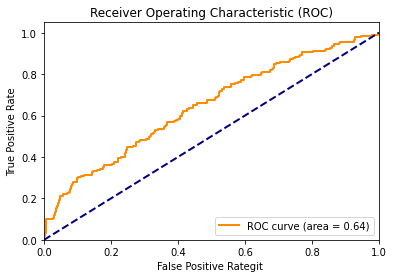

In [25]:
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set

y_pred = best_clf.predict_proba(X_val_old)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_old, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/2_stage_modeling_result.jpg')
plt.show()

# test on new testing data

In [24]:
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set

y_pred = best_clf.predict_proba(X_val_new)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_new, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/2_stage_modeling_result.jpg')
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 0